# Grad NN Final Project

### Prelude

Here is the code for loading and cleaning up the dataset.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'''Data = pd.read_csv("german_credit_data.csv")
Data['Saving accounts'] = Data['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
Data['Saving accounts'] = Data['Saving accounts'].fillna(Data['Saving accounts'].dropna().mean())

Data['Checking account'] = Data['Checking account'].map({"little":0,"moderate":1,"rich":2 });
Data['Checking account'] = Data['Checking account'].fillna(Data['Checking account'].dropna().mean())

Data['race'] = Data['race'].map({"black":0,"white":1}).astype(float)

Data['Housing'] = Data['Housing'].map({"own":0,"free":1,"rent":2}).astype(float)

Data['Purpose'] = Data['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float)

Data['Risk'] = Data['Risk'].map({"good":0,"bad":1}).astype(float)
Data = Data.drop(columns=['Unnamed: 0'])
Data.head(10)'''

import pandas as pd
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

pd.options.mode.chained_assignment = None # muting a trivial warning about PANDAS, don't worry about this
df = pd.read_csv('compas-scores-two-years.csv')
df_cleaned = df.loc[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) 
              & (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]
df_filtered = df_cleaned[['age','sex', 'race', 'juv_fel_count', 'decile_score', 'priors_count', 'is_recid', 'is_violent_recid', 
                   'v_decile_score']]
df_final = df_filtered.join(pd.get_dummies(df_filtered['race']))
df_final["sex"] = (df_final["sex"] == "Male") + 0 ## Use the binary coding for sex.

Data = df_final

Data_wb = Data[(Data['African-American'] | Data['Caucasian']) == 1]

Data = Data_wb
#print (len(Data))

Data = Data.drop(columns=['Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'race', 'is_violent_recid'])

Data = Data.rename(columns={'African-American': 'race'})
Data.head(10)

,age,sex,juv_fel_count,decile_score,priors_count,is_recid,v_decile_score,race
1,34,1,0,3,0,1,1,1
2,24,1,0,4,4,1,3,1
6,41,1,0,6,14,1,2,0
8,39,0,0,1,0,0,1,0
10,27,1,0,4,0,0,4,0
11,23,1,0,6,3,1,4,1
12,37,0,0,1,0,0,1,0
13,41,1,0,4,0,0,2,1
14,47,0,0,1,1,1,1,0
15,31,1,0,3,7,1,2,1


In [50]:
q = df_final[df_final['African-American'] == 1]
print (len(q))
w = df_final[df_final['Caucasian'] == 1]
print (len(w))

print (len(Data))

3175
2103
5278


And here is the code for performing a train-test split, training a logistic regression model, and computing the test accuracy.

In [242]:
X = Data.drop(columns=["is_recid", "race"])
Y = Data['is_recid']

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)

tempX = Data.drop(columns=["is_recid"])
tempY = Data['is_recid']

temptrain_x, temptest_x, temptrain_y, temptest_y = train_test_split(tempX, tempY, test_size=0.2, random_state=137)


# whiteS ARE 0
# blackS ARE 1

test_x_black = test_x[temptest_x['race'] == 1]
test_y_black = test_y[temptest_x['race'] == 1]

test_x_white = test_x[temptest_x['race'] == 0]
test_y_white = test_y[temptest_x['race'] == 0]

train_x_black = train_x[temptrain_x['race'] == 1]
train_x_white = train_x[temptrain_x['race'] == 0]







In [243]:
q = len(temptrain_x[temptrain_x['race'] == 1])

w = len(temptrain_x[temptrain_x['race'] == 0])

race1weight = 1 - (q/(q+w))
race0weight = 1 - (w/(q+w))

print ("Weight for race label 1: ", race1weight)
print ("Weight for race label 0: ", race0weight)

e = len(temptrain_y[temptrain_y == 1])
r = len(temptrain_y[temptrain_y == 0])

risk1weight = 1 - (e/(e+r))
risk0weight = 1 - (r/(e+r))

print ("Weight for risk label 1: ", risk1weight)
print ("Weight for risk label 0: ", risk0weight)


Weight for race label 1:  0.396257697773567
Weight for race label 0:  0.603742302226433
Weight for risk label 1:  0.4971577451444813
Weight for risk label 0:  0.5028422548555187


In [244]:
# Getting low risk/high risk data

test_x_black_lowrisk = test_x_black[test_y_black == 0]
test_y_black_lowrisk = test_y_black[test_y_black == 0]

test_x_black_highrisk = test_x_black[test_y_black == 1]
test_y_black_highrisk = test_y_black[test_y_black == 1]

test_x_white_lowrisk = test_x_white[test_y_white == 0]
test_y_white_lowrisk = test_y_white[test_y_white == 0]

test_x_white_highrisk = test_x_white[test_y_white == 1]
test_y_white_highrisk = test_y_white[test_y_white == 1]

In [245]:
import torch
class Dataset(torch.utils.data.Dataset):
    
    # Create Torch Dataset object.
    def __init__(self, X, Y):

        #X = X.reshape((-1, 1, 64, 64))  
        #self.X = torch.from_numpy(X)
        #self.Y = torch.from_numpy(Y)
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y[index]

        return {'X': X, 'Y': Y}

In [246]:
def train(epoch, net, trainDataLoader, optimizer, criterion, validDataLoader):
    net.train()
    train_loss = 0
    for sample in trainDataLoader:
        inputs, targets = sample['X'], sample['Y']
        #print (inputs, targets)
        optimizer.zero_grad()
        outputs = net.forward(inputs)
        #print ("outputs/targets", outputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size

    net.eval()
    valid_loss = 0
    for sample in validDataLoader:
        inputs, targets = sample['X'], sample['Y']
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        valid_loss += loss.item() * batch_size

    # calculate average losses
    train_loss = train_loss/len(trainDataLoader.sampler)
    valid_loss = valid_loss/len(validDataLoader.sampler)

    if epoch % 1 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    return train_loss, valid_loss


In [247]:
import torch
from torch.autograd import Variable
import sklearn
import numpy as np

scaler = sklearn.preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
test_x_black = scaler.transform(test_x_black)
test_x_white = scaler.transform(test_x_white)
test_x_black_highrisk = scaler.transform(test_x_black_highrisk)
test_x_black_lowrisk = scaler.transform(test_x_black_lowrisk)
test_x_white_highrisk = scaler.transform(test_x_white_highrisk)
test_x_white_lowrisk = scaler.transform(test_x_white_lowrisk)

train_x = torch.from_numpy(train_x.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
test_x_black = torch.from_numpy(test_x_black.astype(np.float32))
test_x_white = torch.from_numpy(test_x_white.astype(np.float32))
test_x_black_highrisk = torch.from_numpy(test_x_black_highrisk.astype(np.float32))
test_x_black_lowrisk = torch.from_numpy(test_x_black_lowrisk.astype(np.float32))
test_x_white_highrisk = torch.from_numpy(test_x_white_highrisk.astype(np.float32))
test_x_white_lowrisk = torch.from_numpy(test_x_white_lowrisk.astype(np.float32))



# Train_y is now a numpy object 
train_y = list(train_y)

# train_y is now a torch object 
train_y = torch.as_tensor(train_y, dtype = torch.float32)
test_y = torch.as_tensor(list(test_y), dtype=torch.float32)
test_y_black = torch.as_tensor(list(test_y_black), dtype=torch.float32)
test_y_white = torch.as_tensor(list(test_y_white), dtype=torch.float32)
test_y_black_highrisk = torch.as_tensor(list(test_y_black_highrisk), dtype=torch.float32)
test_y_black_lowrisk = torch.as_tensor(list(test_y_black_lowrisk), dtype=torch.float32)
test_y_white_highrisk = torch.as_tensor(list(test_y_white_highrisk), dtype=torch.float32)
test_y_white_lowrisk = torch.as_tensor(list(test_y_white_lowrisk), dtype=torch.float32)


train_y = train_y.view(train_y.shape[0],1)
test_y = test_y.view(test_y.shape[0],1)
test_y_black = test_y_black.view(test_y_black.shape[0],1)
test_y_white = test_y_white.view(test_y_white.shape[0],1)
test_y_black_highrisk = test_y_black_highrisk.view(test_y_black_highrisk.shape[0],1)
test_y_black_lowrisk = test_y_black_lowrisk.view(test_y_black_lowrisk.shape[0],1)
test_y_white_highrisk = test_y_white_highrisk.view(test_y_white_highrisk.shape[0],1)
test_y_white_lowrisk = test_y_white_lowrisk.view(test_y_white_lowrisk.shape[0],1)

n_samples,n_features=train_x.shape

In [212]:
def accuracy(model, test_x):
    model.eval()
    with torch.no_grad():
     y_pred=model(test_x)
     y_pred_class=y_pred.round()
     accuracy=(y_pred_class.eq(test_y).sum())/float(test_y.shape[0])
     print(accuracy.item())

In [177]:
# YOUR CODE HERE

import torch
from torch.autograd import Variable


class DNN_model(torch.nn.Module):
 def __init__(self,no_input_features):
    super(DNN_model,self).__init__()
    self.layer1 = torch.nn.Linear(no_input_features,20)
    self.layer2 = torch.nn.Linear(20,20)
    self.layer5 = torch.nn.Linear(20,1)
    
    self.relu1 = torch.nn.ReLU()
    self.relu2 = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    
    self.onlyLayer = torch.nn.Linear(no_input_features, 1)
        
    self.seq = torch.nn.Sequential(
        self.layer1,
        self.relu1,
        self.layer2,
        self.relu2
    )
    #self.seq = torch.nn.Sequential(self.onlyLayer)

 def forward(self,x):
    # YOUR ANSWER HERE
    
    #return self.sigmoid(self.seq(x))
    
    return self.sigmoid(self.layer5(self.seq(x)))

print(train_x.shape)
print (type(train_x))

batch_size = 10
trainSignData = Dataset(train_x, train_y)
print (len(trainSignData))
trainDataLoader = torch.utils.data.DataLoader(trainSignData, shuffle=True, batch_size=batch_size)
testSignData = Dataset(test_x, test_y)
testDataLoader = torch.utils.data.DataLoader(testSignData, shuffle=True, batch_size=batch_size)

dnnmodel = DNN_model(train_x.shape[1])
dnnepochs = 15
dnnlr = 1e-4
criterion = torch.nn.BCELoss()
dnnoptimizer = torch.optim.Adam(dnnmodel.parameters(), lr=dnnlr, weight_decay=1e-5)
for epoch in range(dnnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, dnnmodel, trainDataLoader, dnnoptimizer, criterion, testDataLoader)

torch.save(dnnmodel, "dnnmodel.pt")

torch.Size([4222, 6])
<class 'torch.Tensor'>
4222
epoch 0
Epoch: 0 	Training Loss: 0.680538 	Validation Loss: 0.668542
epoch 1
Epoch: 1 	Training Loss: 0.654080 	Validation Loss: 0.643780
epoch 2
Epoch: 2 	Training Loss: 0.631108 	Validation Loss: 0.624549
epoch 3
Epoch: 3 	Training Loss: 0.615943 	Validation Loss: 0.612866
epoch 4
Epoch: 4 	Training Loss: 0.606745 	Validation Loss: 0.607166
epoch 5
Epoch: 5 	Training Loss: 0.602971 	Validation Loss: 0.605362
epoch 6
Epoch: 6 	Training Loss: 0.600978 	Validation Loss: 0.604186
epoch 7
Epoch: 7 	Training Loss: 0.599538 	Validation Loss: 0.603728
epoch 8
Epoch: 8 	Training Loss: 0.598569 	Validation Loss: 0.602851
epoch 9
Epoch: 9 	Training Loss: 0.598798 	Validation Loss: 0.603992
epoch 10
Epoch: 10 	Training Loss: 0.597393 	Validation Loss: 0.602991
epoch 11
Epoch: 11 	Training Loss: 0.596629 	Validation Loss: 0.601496
epoch 12
Epoch: 12 	Training Loss: 0.596137 	Validation Loss: 0.601481
epoch 13
Epoch: 13 	Training Loss: 0.595493 	Va

In [178]:
#print (dnnmodel.forward(test_x).round())

accuracy(dnnmodel, test_x)

0.6865530014038086


#### Q4: Show the ROC curves for the black and white subgroups, and plot the points corresponding to the different strategies clearly identified. The resulting curve should look like the ROC curve in the FICO score case study that was discussed in class.  (5 points)

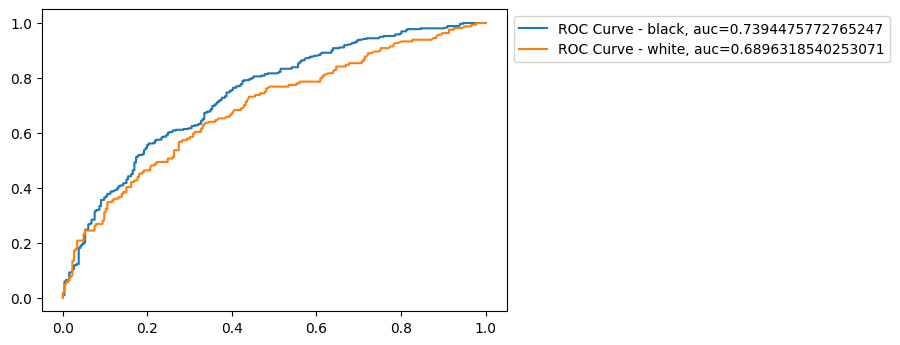

In [179]:
import matplotlib.pyplot as plt
from sklearn import metrics

from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

blackPreds = dnnmodel(test_x_black).detach()
whitePreds = dnnmodel(test_x_white).detach()

fpr_m, tpr_m, thresholds_m = metrics.roc_curve(test_y_black, blackPreds)
auc = metrics.roc_auc_score(test_y_black, blackPreds)
plt.plot(fpr_m,tpr_m,label="ROC Curve - black, auc="+str(auc))

fpr_f, tpr_f, thresholds_f = metrics.roc_curve(test_y_white, whitePreds)
auc = metrics.roc_auc_score(test_y_white, whitePreds)
plt.plot(fpr_f,tpr_f,label="ROC Curve - white, auc="+str(auc))

# lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minBlackThreshold else 0)
# lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minWhiteThreshold else 0)


# ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='black', marker='^', s=100, label='Max Profit Black')
# ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='green', marker='^', s= 100, label="Max Profit White")

plt.legend(loc=0, bbox_to_anchor=(1,1))

#### Q5: (i) Do a calibration plot that plots the fraction of defendants recidividating within two years as a function of the predicted probability of recidivism, for black defendants and white defendants. (ii) Comment (in a couple of sentences) if you believe that the score satisfies sufficiency across racial groups.      (5 points)

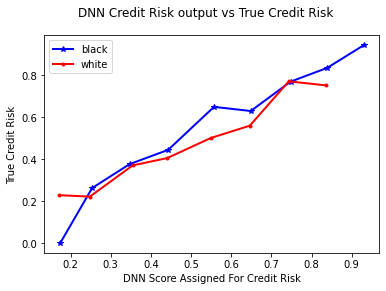

In [182]:
# YOUR CODE HERE 
from sklearn.calibration import calibration_curve
y_m, x_m = calibration_curve(
    test_y_black, 
    blackPreds, 
    n_bins=10)

y_f, x_f = calibration_curve(
    test_y_white, 
    whitePreds, 
    n_bins=10)






fig, ax = plt.subplots()

plt.plot(x_m, y_m, color='blue', 
         marker='*', 
         linewidth = 2, 
         label='black')

plt.plot(x_f, y_f, color='red', 
         marker='.', 
         linewidth = 2, 
         label='white')



# # reference line, legends, and axis labels
ax.set_xlabel('DNN Score Assigned For Credit Risk')
ax.set_ylabel('True Credit Risk')
fig.suptitle('DNN Credit Risk output vs True Credit Risk')
plt.legend()
plt.show()







Being sufficient means $Y \perp A \mid R$.  Sufficiency doesn't hold here, as whites are getting predicted to have higher credit risk even when their true credit risk isn't as high (the lines don't match up).  So, whites are getting discriminated against.

#### Q6: (i) Plot the distributions of scores received by the positive class (recidivists) and the distribution of scores received by the negative class (non-recidivists) for black and white defendants. (ii) Based on these plots, comment (in a couple of sentences) if this score satisfies separation.  (5 points)

/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_72239/1024980358.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(whiteLowRiskPreds,
/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_72239/1024980358.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(blackLowRiskPreds,


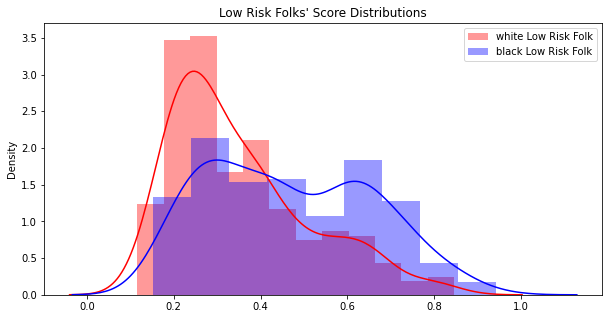

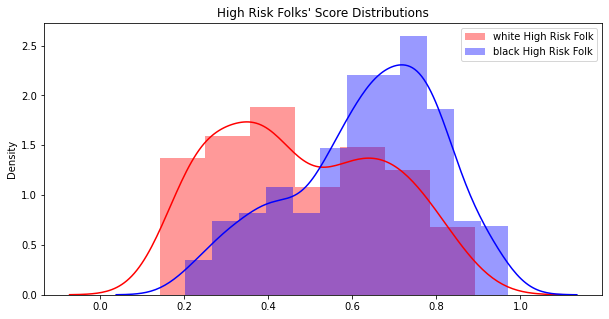

In [233]:
# YOUR CODE HERE

#print (test_y_white.head())

def makeSeparationGraphs(test_x_black_lowrisk, test_x_black_highrisk, test_x_white_lowrisk, test_x_white_highrisk):
    blackLowRiskPreds = dnnmodel(test_x_black_lowrisk).detach()
    blackHighRiskPreds = dnnmodel(test_x_black_highrisk).detach()

    whiteLowRiskPreds = dnnmodel(test_x_white_lowrisk).detach()
    whiteHighRiskPreds = dnnmodel(test_x_white_highrisk).detach()

    import seaborn as sns
    plt.figure(figsize=(10,5))
    sns.distplot(whiteLowRiskPreds, 
                 color="red", 
                 label="white Low Risk Folk").set(title = "Low Risk Folks' Score Distributions")
    sns.distplot(blackLowRiskPreds, 
                 color="blue", 
                 label="black Low Risk Folk").set(title = "Low Risk Folks' Score Distributions")
    plt.legend()

    plt.figure(figsize=(10,5))
    sns.distplot(whiteHighRiskPreds, 
                 color="red", 
                 label="white High Risk Folk").set(title = "High Risk Folks' Score Distributions")
    sns.distplot(blackHighRiskPreds, 
                 color="blue", 
                 label="black High Risk Folk").set(title = "High Risk Folks' Score Distributions")
    plt.legend()
    
makeSeparationGraphs(test_x_black_lowrisk, test_x_black_highrisk, test_x_white_lowrisk, test_x_white_highrisk)





Separation means that $R \perp A \mid Y$.  So given the true label of recidivism, the logistic regression output must be independent of the race sensitive variable $A$.  This does NOT satisfy separation, because for both labels (non-recidivists and recidivists), we can see that the model outputted significantly lower scores for white people.

In [184]:
def falseaLossTrueLossSeparationHelper(model, data, labels, verbose=True):
    data = pd.DataFrame(data.numpy())
    labels = pd.DataFrame(labels.numpy())
    raceIndex = 2
    xd = data[raceIndex] < 0
    dx = (labels == 1).squeeze()

    whiteTrueData = data[(data[raceIndex] < 0) & (labels == 1).squeeze()]
    whiteFalseData = data[(data[raceIndex] < 0) & (labels == 0).squeeze()]

    blackTrueData = data[(data[raceIndex] > 0) & (labels == 1).squeeze()]
    blackFalseData = data[(data[raceIndex] > 0) & (labels == 0).squeeze()]
    
    whiteTrueData = torch.tensor(whiteTrueData.values)
    whiteFalseData = torch.tensor(whiteFalseData.values)
    
    blackTrueData = torch.tensor(blackTrueData.values)
    blackFalseData = torch.tensor(blackFalseData.values)
    
    whiteTruePreds = model(whiteTrueData)
    whiteFalsePreds = model(whiteFalseData)
    
    blackTruePreds = model(blackTrueData)
    blackFalsePreds = model(blackFalseData)
    
    whiteTruePosProb = (torch.sum(whiteTruePreds.round())/len(whiteTrueData))
    whiteFalsePosProb = (torch.sum(whiteFalsePreds.round())/len(whiteFalseData))
    
    blackTruePosProb = (torch.sum(blackTruePreds.round())/len(blackTrueData))
    blackFalsePosProb = (torch.sum(blackFalsePreds.round())/len(blackFalseData))
    
    print ("whiteTruePosProb(prob of marking a high risk white): ", whiteTruePosProb.detach())
    print ("blackTruePosProb(prob of marking a high risk black): ", blackTruePosProb.detach())

    print ("whiteFalsePosProb(prob of marking a low risk white): ", whiteFalsePosProb.detach())    
    print ("blackFalsePosProb(prob of marking a low risk black): ", blackFalsePosProb.detach())
    
    falseLoss = abs(whiteFalsePosProb - blackFalsePosProb)
    trueLoss = abs(whiteTruePosProb - blackTruePosProb)
    
    # R = model output
    # A = race (0 = white), (1 = black)
    # Y = 0 (low risk), Y = 1 (high risk)
    
    if verbose:
        print ("|P(R = 1 | A = 1, Y = 0) - P(R = 1 | A = 0, Y = 0)| = ", falseLoss.item())
        print ("|P(R = 1 | A = 1, Y = 1) - P(R = 1 | A = 0, Y = 1)| = ", trueLoss.item())
    return falseLoss, trueLoss
    
def maxSeparation(model, data, labels):
    res = falseaLossTrueLossSeparationHelper(model, data, labels)
    return max(res[0].item(), res[1].item())
    
def separation(model, data, labels):
    maxSep = maxSeparation(model, data, labels)
    eps = 0.05
    return (maxSep < eps)

def separationLoss(model, data, labels):
    falseLoss, trueLoss = falseaLossTrueLossSeparationHelper(model, data, labels, verbose=False)
    return falseLoss + trueLoss

print ("Does the model satisfy separation: ", separation(dnnmodel, test_x, test_y))

whiteTruePosProb(prob of marking a high risk white):  tensor(0.6538)
blackTruePosProb(prob of marking a high risk black):  tensor(1.)
whiteFalsePosProb(prob of marking a low risk white):  tensor(0.2925)
blackFalsePosProb(prob of marking a low risk black):  tensor(0.8889)
|P(R = 1 | A = 1, Y = 0) - P(R = 1 | A = 0, Y = 0)| =  0.5963459014892578
|P(R = 1 | A = 1, Y = 1) - P(R = 1 | A = 0, Y = 1)| =  0.34623217582702637
Does the model satisfy separation:  False


In [185]:
# creating new dataset

raceX = Data.drop(columns=['is_recid', 'race'])
raceY = Data['race']

racetrain_x, racetest_x, racetrain_y, racetest_y = train_test_split(raceX, raceY, test_size=0.2, random_state=137)

scaler = sklearn.preprocessing.StandardScaler()
racetrain_x = scaler.fit_transform(racetrain_x)
racetest_x = scaler.transform(racetest_x)

racetrain_x = torch.from_numpy(racetrain_x.astype(np.float32))
racetest_x = torch.from_numpy(racetest_x.astype(np.float32))

# Train_y is now a numpy object 
racetrain_y = list(racetrain_y)

# train_y is now a torch object 
racetrain_y = torch.as_tensor(racetrain_y, dtype = torch.float32)
racetest_y = torch.as_tensor(list(racetest_y), dtype=torch.float32)

racetrain_y = racetrain_y.view(racetrain_y.shape[0],1)
racetest_y = racetest_y.view(racetest_y.shape[0],1)

n_samples,n_features=racetrain_x.shape


In [192]:
from copy import deepcopy

batch_size = 10
raceTrainData = Dataset(racetrain_x, racetrain_y)
raceTrainDataLoader = torch.utils.data.DataLoader(raceTrainData, shuffle=True, batch_size=batch_size)
raceTestData = Dataset(racetest_x, racetest_y)
raceTestDataLoader = torch.utils.data.DataLoader(raceTestData, shuffle=True, batch_size=batch_size)


'''for child in dnnmodel.seq.children():
    for param in child.parameters():
        print (param)'''

savedModel = deepcopy(dnnmodel)

class RaceDNNModel(torch.nn.Module):
    def __init__(self, savedModel):
        super(RaceDNNModel,self).__init__()
        self.seq = savedModel.seq
        
        self.racelayer1 = torch.nn.Linear(20,20)
        self.racelayer2 = torch.nn.Linear(20,20)
        self.racelayer3 = torch.nn.Linear(20,1)
            
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
        self.raceseq = torch.nn.Sequential(
            self.racelayer3,
            self.sigmoid
        )
        
        
        for child in self.seq.children():
            for param in child.parameters():
                #print (param)
                param.requires_grad = False

        self.seq.eval()
    
    def forward(self, x):
        return self.raceseq(self.seq(x))
        
racednnmodel = RaceDNNModel(savedModel)

racednnepochs = 15
racednnlr = 1e-4
def BCELoss_class_weighted(weights):
    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)
    return loss


criterion = BCELoss_class_weighted(weights = [2*race0weight, 2*race1weight])
racednnoptimizer = torch.optim.Adam([param for param in racednnmodel.parameters() if param.requires_grad == True], lr=racednnlr, weight_decay = 1e-5)
for epoch in range(racednnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, racednnmodel, raceTrainDataLoader, racednnoptimizer, criterion, raceTestDataLoader)

accuracy(racednnmodel, racetest_x)
torch.save(racednnmodel, "racednnmodel.pt")

        
    






epoch 0
Epoch: 0 	Training Loss: 0.759750 	Validation Loss: 0.758811
epoch 1
Epoch: 1 	Training Loss: 0.729663 	Validation Loss: 0.727315
epoch 2
Epoch: 2 	Training Loss: 0.703987 	Validation Loss: 0.701465
epoch 3
Epoch: 3 	Training Loss: 0.683921 	Validation Loss: 0.680532
epoch 4
Epoch: 4 	Training Loss: 0.667445 	Validation Loss: 0.663319
epoch 5
Epoch: 5 	Training Loss: 0.654546 	Validation Loss: 0.649569
epoch 6
Epoch: 6 	Training Loss: 0.644696 	Validation Loss: 0.638561
epoch 7
Epoch: 7 	Training Loss: 0.636686 	Validation Loss: 0.628879
epoch 8
Epoch: 8 	Training Loss: 0.630519 	Validation Loss: 0.621620
epoch 9
Epoch: 9 	Training Loss: 0.626196 	Validation Loss: 0.615972
epoch 10
Epoch: 10 	Training Loss: 0.622689 	Validation Loss: 0.611922
epoch 11
Epoch: 11 	Training Loss: 0.620504 	Validation Loss: 0.608390
epoch 12
Epoch: 12 	Training Loss: 0.618516 	Validation Loss: 0.605847
epoch 13
Epoch: 13 	Training Loss: 0.617199 	Validation Loss: 0.603207
epoch 14
Epoch: 14 	Traini

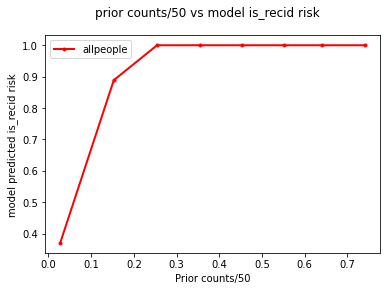

In [187]:
y_t, x_pc = calibration_curve(
    dnnmodel.forward(train_x).detach().round(),
    [x/50 for x in temptrain_x['priors_count']],
    n_bins=10
)

fig, ax = plt.subplots()

plt.plot(x_pc, y_t, color='red', 
         marker='.', 
         linewidth = 2, 
         label='allpeople')



# # reference line, legends, and axis labels
ax.set_xlabel('Prior counts/50')
ax.set_ylabel('model predicted is_recid risk')
fig.suptitle('prior counts/50 vs model is_recid risk')
plt.legend()
plt.show()


Average Feature Importances
age :  -0.000
sex :  0.002
juv_fel_count :  0.000
decile_score :  -0.006
priors_count :  -0.009
v_decile_score :  -0.003


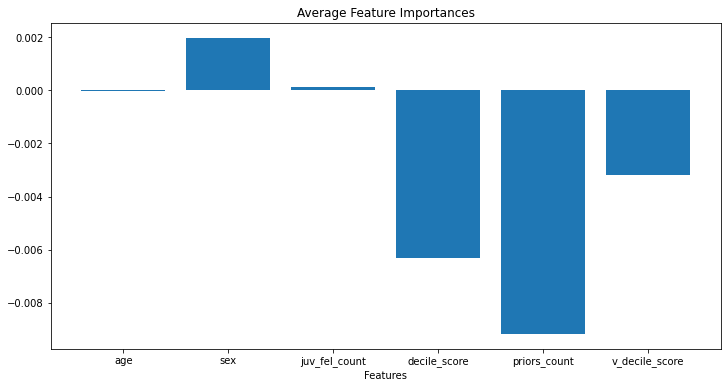

In [201]:
from captum.insights.attr_vis.features import GeneralFeature
from captum.insights import AttributionVisualizer, Batch

from captum.attr import IntegratedGradients, DeepLift
from captum.attr import LayerConductance
from captum.attr import NeuronConductance


def baseline_func(input):
    return input * 0

def formatted_data_iter(testDataLoader):
    dataloader = iter(testDataLoader)
    while True:
        images, labels = next(dataloader)
        yield Batch(inputs=images, labels=labels)

'''GeneralFeature("sex"),
        GeneralFeature("juv_fel_count"),
        GeneralFeature("decile_score"),
        GeneralFeature("priors_count"),
        GeneralFeature("v_decile_score")'''

ig = IntegratedGradients(racednnmodel)

test_input_tensor = deepcopy(test_x)

test_input_tensor.requires_grad_()

#print (test_input_tensor)
attr, delta = ig.attribute(test_input_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        
feature_names = "age sex juv_fel_count decile_score priors_count v_decile_score".split(" ")

#print (feature_names)
        
visualize_importances(feature_names, np.mean(attr, axis=0))



Average Neuron Importances For Hidden Layer 1
0 :  -0.004
1 :  -0.002
2 :  -0.007
3 :  0.000
4 :  0.008
5 :  0.001
6 :  -0.002
7 :  0.004
8 :  -0.022
9 :  -0.002
10 :  0.000
11 :  -0.007
12 :  0.001
13 :  0.001
14 :  -0.002
15 :  -0.002
16 :  -0.000
17 :  0.002
18 :  0.012
19 :  0.005
Average Neuron Importances For Hidden Layer 2
0 :  -0.005
1 :  0.001
2 :  -0.000
3 :  0.004
4 :  0.000
5 :  0.000
6 :  -0.011
7 :  0.000
8 :  0.006
9 :  0.003
10 :  0.003
11 :  0.001
12 :  0.008
13 :  -0.004
14 :  0.002
15 :  -0.015
16 :  -0.003
17 :  -0.000
18 :  -0.005
19 :  0.000


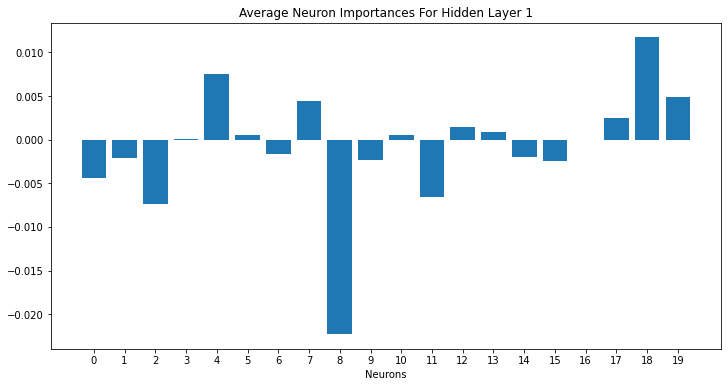

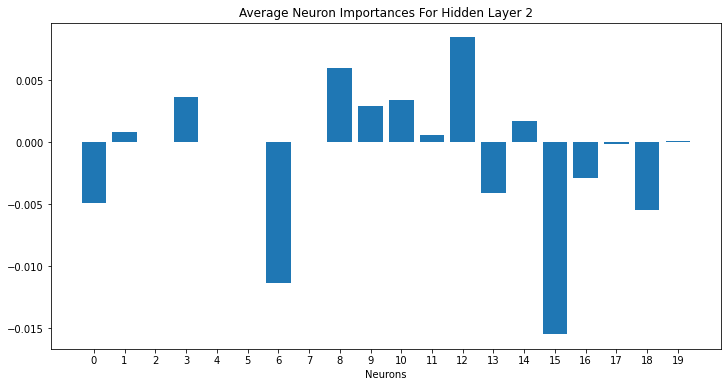

In [197]:
# Layer Conductance

cond = LayerConductance(racednnmodel, racednnmodel.seq[1]) # relu1
cond_vals = cond.attribute(test_input_tensor,target=0)
cond_vals = cond_vals.detach().numpy()
visualize_importances(range(20),np.mean(cond_vals, axis=0),title="Average Neuron Importances For Hidden Layer 1", axis_title="Neurons")

cond2 = LayerConductance(racednnmodel, racednnmodel.seq[3]) # relu2
cond_vals2 = cond2.attribute(test_input_tensor,target=0)
cond_vals2 = cond_vals2.detach().numpy()
visualize_importances(range(20),np.mean(cond_vals2, axis=0),title="Average Neuron Importances For Hidden Layer 2", axis_title="Neurons")



Average Feature Importances for Output Neuron0
age :  -0.000
sex :  0.002
juv_fel_count :  0.000
decile_score :  -0.006
priors_count :  -0.009
v_decile_score :  -0.003


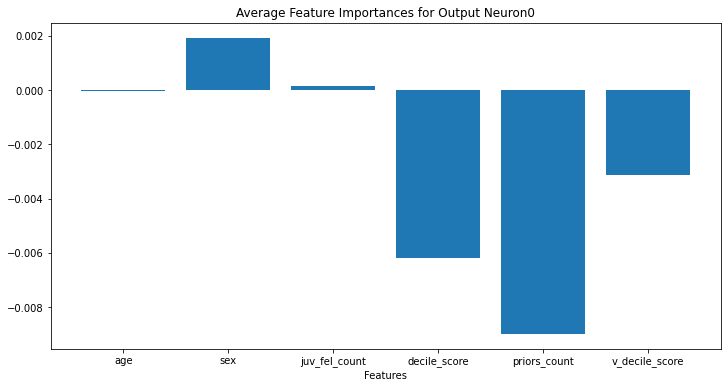

In [200]:
output_neuron_cond = NeuronConductance(racednnmodel, racednnmodel.sigmoid)
output_neuron_cond_vals = output_neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=0)
visualize_importances(feature_names, output_neuron_cond_vals.mean(dim=0).detach().numpy(), title="Average Feature Importances for Output Neuron0")



torch.float32
torch.float32


/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_72239/1024980358.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(whiteLowRiskPreds,
/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_72239/1024980358.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(blackLowRiskPreds,


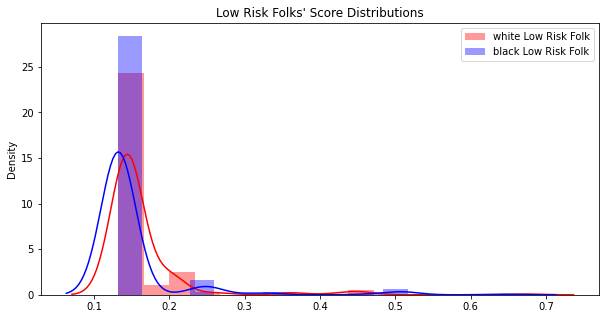

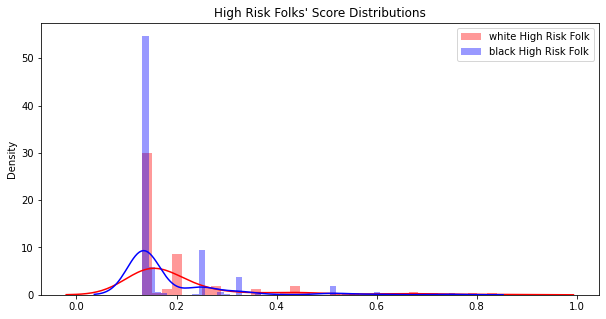

In [251]:
# median operation on input features

def upperbinsearch(arr, x):
    low = 0
    high = len(arr)
    while low + 1 < high:
        mid = low + (high - low)//2
        if arr[mid] <= x:
            low = mid
        else:
            high = mid
    return low
    
def lowerbinsearch(arr, x):
    low = 0
    high = len(arr)
    while low + 1 < high:
        mid = low + (high - low)//2
        if arr[mid] < x:
            low = mid
        else:
            high = mid
    if high < len(arr) and arr[high] <= x:
        return high
    else:
        return low
    
def calculatePercentile(arr, x):
    lowerbinresult = lowerbinsearch(arr, x)
    upperbinresult = upperbinsearch(arr, x)
    avgresult = (lowerbinresult + upperbinresult)/2
    return avgresult/len(arr)

import statistics

def convertDataset(groups, valsToSortedList, featureImportances):
    numFeatures = groups[0].shape[1]
    
    test_x_black_df = pd.DataFrame(groups[0].numpy())
    test_x_white_df = pd.DataFrame(groups[1].numpy())
    
    featureImportancesSorted = sorted([abs(robot) for robot in featureImportances], reverse = True)
    maxImportance = featureImportancesSorted[0]
    
    groupNames = [("black", test_x_black_df), ("white", test_x_white_df)]
    
    for tup in groupNames:
        curGroup = tup[0]
        data = tup[1]
        for dataCounter in range(len(data)):
            row = data.iloc[dataCounter]

            for i in range(numFeatures):
                #print(valsToSortedList[i][curGroup])
                percentile = calculatePercentile(valsToSortedList[i][curGroup], data.at[dataCounter, i])
                allGroupsAtPercentile = list()
                for group in valsToSortedList[i]:
                    groupArr = valsToSortedList[i][group]
                    valForGroup = groupArr[min(int(percentile * len(groupArr)), len(groupArr) - 1)]
                    allGroupsAtPercentile.append(valForGroup)

                medianVal = statistics.median(allGroupsAtPercentile)

                # replace value with weighted average of median and original value
                weight = 0
                #weight = abs(featureImportances[i])/maxImportance
                origVal = data.at[dataCounter, i]
                data.at[dataCounter, i] = (weight*medianVal) + ((1 - weight)*origVal)
    return (test_x_black_df, test_x_white_df)

def getFeatureDistributions(groups, df_input = False):
    
    #valsToSortedList = defaultdict(lambda: dict()) # maps sensitive attribute value to a map of columns to sorted lists
    numFeatures = groups[0].shape[1]
    valsToSortedList = [dict() for i in range(numFeatures)]
    
    if df_input == False:
        train_x_black_df = pd.DataFrame(groups[0].numpy())
        train_x_white_df = pd.DataFrame(groups[1].numpy())
    else:
        train_x_black_df = groups[0]
        train_x_white_df = groups[1]
    for i in range(numFeatures): # loop over all features
        
        whiteCol = train_x_white_df.iloc[:,i].to_numpy().tolist()
        whiteCol.sort()
        
        blackCol = train_x_black_df.iloc[:,i].to_numpy().tolist()
        blackCol.sort()
        
        valsToSortedList[i]['black'] = blackCol
        valsToSortedList[i]['white'] = whiteCol
        
    return valsToSortedList



valsToSortedList = getFeatureDistributions([train_x_black, train_x_white], df_input = True)
test_x_black_df, test_x_white_df = convertDataset([test_x_black, test_x_white], valsToSortedList, output_neuron_cond_vals.mean(dim=0).detach().numpy().tolist())

dtype = test_x_black.dtype

test_x_black_med, test_x_white_med = torch.tensor(test_x_black_df.values, dtype = dtype), torch.tensor(test_x_white_df.values, dtype = dtype)

#print (test_x_black_med.shape)


#print (test_x_black.shape)

test_x_black_lowrisk_df, test_x_white_lowrisk_df = convertDataset([test_x_black_lowrisk, test_x_white_lowrisk], valsToSortedList, output_neuron_cond_vals.mean(dim=0).detach().numpy().tolist())
test_x_black_highrisk_df, test_x_white_highrisk_df = convertDataset([test_x_black_highrisk, test_x_white_highrisk], valsToSortedList, output_neuron_cond_vals.mean(dim=0).detach().numpy().tolist())
test_x_black_lowrisk_med, test_x_white_lowrisk_med = torch.tensor(test_x_black_lowrisk_df.values, dtype=dtype), torch.tensor(test_x_white_lowrisk_df.values, dtype=dtype)
test_x_black_highrisk_med, test_x_white_highrisk_med = torch.tensor(test_x_black_highrisk_df.values, dtype=dtype), torch.tensor(test_x_white_highrisk_df.values, dtype=dtype)

print (test_x_black_lowrisk_med.dtype)
print (test_x_black_lowrisk.dtype)

makeSeparationGraphs(test_x_black_lowrisk_med, test_x_black_highrisk_med, test_x_white_lowrisk_med, test_x_white_highrisk_med)






fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(15, 20))

feature_names.append('race')
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    print (i, (ax,col))
    x = Data[col]
    y = Y
    #x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs is_recid')
    ax.set_xlabel(col)
    ax.set_ylabel('is_recid')